In [24]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'

def load(test=False, cols=None):
    """testがTrueの場合はFTESTからデータを読み込み、Falseの場合はFTRAINから読み込みます。
    colsにリストが渡された場合にはそのカラムに関するデータのみ返します。
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) # pandasのdataframeを使用

    # スペースで句切られているピクセル値をnumpy arrayに変換
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # カラムに関連するデータのみを抽出
        df = df[list(cols) + ['Image']]

    print(df.count())  # カラム毎に値が存在する行数を出力
    df = df.dropna()  # データが欠けている行は捨てる

    X = np.vstack(df['Image'].values) / 255.  # 0から1の値に変換
    X = X.astype(np.float32)

    if not test:  # ラベルが存在するのはFTRAINのみ
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # -1から1の値に変換
        X, y = shuffle(X, y, random_state=42)  # データをシャッフル
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100, input_dim=9216))
model.add(Activation('relu'))
model.add(Dense(30))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
hist = model.fit(X, y, nb_epoch=100, validation_split=0.2)

Train on 1712 samples, validate on 428 samples
Epoch 1/100


C:\Users\tetsu\Anaconda3\envs\keypoint\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


1712/1712 [==============================] - 0s 190us/step - loss: 0.0446 - val_loss: 0.0139
Epoch 2/100
1712/1712 [==============================] - 0s 103us/step - loss: 0.0133 - val_loss: 0.0126
Epoch 3/100
1712/1712 [==============================] - 0s 106us/step - loss: 0.0112 - val_loss: 0.0106
Epoch 4/100
1712/1712 [==============================] - 0s 121us/step - loss: 0.0099 - val_loss: 0.0097
Epoch 5/100
1712/1712 [==============================] - 0s 103us/step - loss: 0.0090 - val_loss: 0.0095
Epoch 6/100
1712/1712 [==============================] - 0s 98us/step - loss: 0.0085 - val_loss: 0.0086
Epoch 7/100
1712/1712 [==============================] - 0s 101us/step - loss: 0.0080 - val_loss: 0.0081
Epoch 8/100
1712/1712 [==============================] - 0s 104us/step - loss: 0.0077 - val_loss: 0.0077
Epoch 9/100
1712/1712 [==============================] - 0s 105us/step - loss: 0.0074 - val_loss: 0.0079
Epoch 10/100
1712/1712 [==============================] - 0s 142us/s

1712/1712 [==============================] - 0s 105us/step - loss: 0.0026 - val_loss: 0.0037
Epoch 79/100
1712/1712 [==============================] - 0s 105us/step - loss: 0.0026 - val_loss: 0.0036
Epoch 80/100
1712/1712 [==============================] - 0s 101us/step - loss: 0.0025 - val_loss: 0.0036
Epoch 81/100
1712/1712 [==============================] - 0s 110us/step - loss: 0.0025 - val_loss: 0.0036
Epoch 82/100
1712/1712 [==============================] - 0s 116us/step - loss: 0.0025 - val_loss: 0.0036
Epoch 83/100
1712/1712 [==============================] - 0s 123us/step - loss: 0.0025 - val_loss: 0.0036
Epoch 84/100
1712/1712 [==============================] - 0s 204us/step - loss: 0.0025 - val_loss: 0.0036
Epoch 85/100
1712/1712 [==============================] - 0s 108us/step - loss: 0.0024 - val_loss: 0.0038
Epoch 86/100
1712/1712 [==============================] - 0s 123us/step - loss: 0.0025 - val_loss: 0.0044
Epoch 87/100
1712/1712 [==============================] - 0

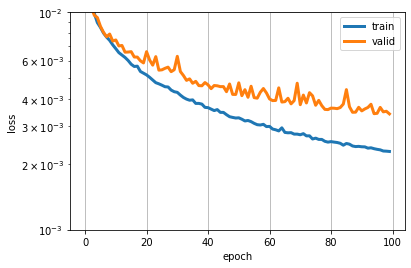

In [26]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], linewidth=3, label='train')
plt.plot(hist.history['val_loss'], linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)
plt.yscale('log')
plt.show()

In [27]:
def load2d(test=False, cols=None):
    X, y = load(test, cols)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='x', s=10)

ImageId    1783
Image      1783
dtype: int64


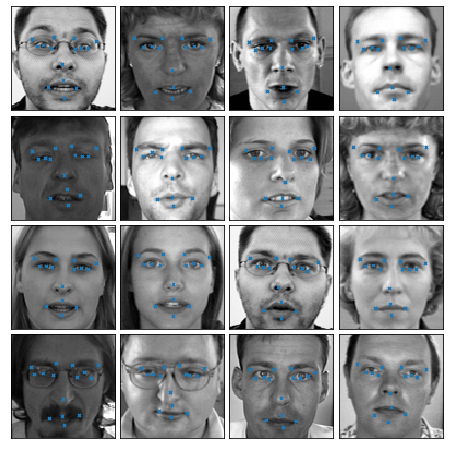

In [28]:
X_test, _ = load(test=True)
y_test = model.predict(X_test)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

plt.show()

In [45]:
json_string = model.to_json()
open('model1_architecture.json', 'w').write(json_string)
model.save_weights('model1_weights.h5')

In [46]:
X.shape

(2140, 1, 96, 96)

In [47]:
y.shape

(2140, 30)

In [52]:
# Use CNN
from keras.layers import Convolution2D, MaxPool2D, Flatten

# X, y = load2d()
model2 = Sequential()

# model2.add(Conv2D(32, (3, 3), input_shape=(1, 96, 96)))
# model2.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,96,96)))
model2.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,96,96), data_format='channels_first'))
# model2.add(Conv2D(32, (3, 3), input_shape=(1, 96, 96)))
# model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Convolution2D(64, (2, 2)))
model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Convolution2D(128, (2, 2)))
model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(Dense(30))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model2.compile(loss='mean_squared_error', optimizer=sgd)

In [53]:
hist2 = model2.fit(X, y, nb_epoch=1000, validation_split=0.2)

C:\Users\tetsu\Anaconda3\envs\keypoint\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 1712 samples, validate on 428 samples
Epoch 1/1000
1712/1712 [==============================] - 1s 484us/step - loss: 0.0333 - val_loss: 0.0083
Epoch 2/1000
1712/1712 [==============================] - 0s 240us/step - loss: 0.0080 - val_loss: 0.0069
Epoch 3/1000
1712/1712 [==============================] - 0s 238us/step - loss: 0.0068 - val_loss: 0.0061
Epoch 4/1000
1712/1712 [==============================] - 0s 246us/step - loss: 0.0060 - val_loss: 0.0055
Epoch 5/1000
1712/1712 [==============================] - 0s 237us/step - loss: 0.0055 - val_loss: 0.0051
Epoch 6/1000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0051 - val_loss: 0.0049
Epoch 7/1000
1712/1712 [==============================] - 0s 247us/step - loss: 0.0048 - val_loss: 0.0046
Epoch 8/1000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0046 - val_loss: 0.0045
Epoch 9/1000
1712/1712 [==============================] - 0s 247us/step - loss: 0.0045 - val_loss: 0.0044

1712/1712 [==============================] - 0s 243us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 78/1000
1712/1712 [==============================] - 0s 238us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 79/1000
1712/1712 [==============================] - 0s 240us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 80/1000
1712/1712 [==============================] - 0s 244us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 81/1000
1712/1712 [==============================] - 0s 243us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 82/1000
1712/1712 [==============================] - 0s 237us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 83/1000
1712/1712 [==============================] - 0s 245us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 84/1000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 85/1000
1712/1712 [==============================] - 0s 243us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 86/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 263us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 153/1000
1712/1712 [==============================] - 0s 273us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 154/1000
1712/1712 [==============================] - 0s 266us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 155/1000
1712/1712 [==============================] - 0s 258us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 156/1000
1712/1712 [==============================] - 0s 262us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 157/1000
1712/1712 [==============================] - 0s 256us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 158/1000
1712/1712 [==============================] - 0s 265us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 159/1000
1712/1712 [==============================] - 0s 265us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 160/1000
1712/1712 [==============================] - 0s 258us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 161/1000
1712/1712 [=================

Epoch 228/1000
1712/1712 [==============================] - 0s 241us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 229/1000
1712/1712 [==============================] - 0s 243us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 230/1000
1712/1712 [==============================] - 0s 241us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 231/1000
1712/1712 [==============================] - 0s 244us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 232/1000
1712/1712 [==============================] - 0s 246us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 233/1000
1712/1712 [==============================] - 0s 236us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 234/1000
1712/1712 [==============================] - 0s 237us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 235/1000
1712/1712 [==============================] - 0s 245us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 236/1000
1712/1712 [==============================] - 0s 244us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 237/1000
1712/1712 [==

Epoch 304/1000
1712/1712 [==============================] - 0s 232us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 305/1000
1712/1712 [==============================] - 0s 237us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 306/1000
1712/1712 [==============================] - 0s 243us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 307/1000
1712/1712 [==============================] - 0s 244us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 308/1000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 309/1000
1712/1712 [==============================] - 0s 231us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 310/1000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 311/1000
1712/1712 [==============================] - 0s 247us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 312/1000
1712/1712 [==============================] - 0s 238us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 313/1000
1712/1712 [==

Epoch 380/1000
1712/1712 [==============================] - 0s 242us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 381/1000
1712/1712 [==============================] - 0s 234us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 382/1000
1712/1712 [==============================] - 0s 232us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 383/1000
1712/1712 [==============================] - 0s 233us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 384/1000
1712/1712 [==============================] - 0s 243us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 385/1000
1712/1712 [==============================] - 0s 231us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 386/1000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 387/1000
1712/1712 [==============================] - 0s 233us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 388/1000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 389/1000
1712/1712 [==

Epoch 456/1000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 457/1000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 458/1000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 459/1000
1712/1712 [==============================] - 0s 235us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 460/1000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 461/1000
1712/1712 [==============================] - 0s 236us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 462/1000
1712/1712 [==============================] - 0s 229us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 463/1000
1712/1712 [==============================] - 0s 231us/step - loss: 0.0011 - val_loss: 0.0019
Epoch 464/1000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0011 - val_loss: 0.0019
Epoch 465/1000
1712/1712 [==

1712/1712 [==============================] - 0s 231us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 532/1000
1712/1712 [==============================] - 0s 245us/step - loss: 0.0010 - val_loss: 0.0019
Epoch 533/1000
1712/1712 [==============================] - 0s 253us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 534/1000
1712/1712 [==============================] - 0s 251us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 535/1000
1712/1712 [==============================] - 0s 244us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 536/1000
1712/1712 [==============================] - 0s 236us/step - loss: 0.0010 - val_loss: 0.0019
Epoch 537/1000
1712/1712 [==============================] - 0s 237us/step - loss: 0.0010 - val_loss: 0.0019
Epoch 538/1000
1712/1712 [==============================] - 0s 233us/step - loss: 0.0010 - val_loss: 0.0019
Epoch 539/1000
1712/1712 [==============================] - 0s 237us/step - loss: 0.0010 - val_loss: 0.0018
Epoch 540/1000
1712/1712 [=================

1712/1712 [==============================] - 0s 248us/step - loss: 9.3504e-04 - val_loss: 0.0018
Epoch 606/1000
1712/1712 [==============================] - 0s 246us/step - loss: 9.3478e-04 - val_loss: 0.0019
Epoch 607/1000
1712/1712 [==============================] - 0s 251us/step - loss: 9.3347e-04 - val_loss: 0.0018
Epoch 608/1000
1712/1712 [==============================] - 0s 240us/step - loss: 9.3232e-04 - val_loss: 0.0018
Epoch 609/1000
1712/1712 [==============================] - 0s 233us/step - loss: 9.3389e-04 - val_loss: 0.0018
Epoch 610/1000
1712/1712 [==============================] - 0s 231us/step - loss: 9.3007e-04 - val_loss: 0.0018
Epoch 611/1000
1712/1712 [==============================] - 0s 232us/step - loss: 9.2635e-04 - val_loss: 0.0018
Epoch 612/1000
1712/1712 [==============================] - 0s 234us/step - loss: 9.2706e-04 - val_loss: 0.0018
Epoch 613/1000
1712/1712 [==============================] - 0s 235us/step - loss: 9.2564e-04 - val_loss: 0.0018
Epoch 6

1712/1712 [==============================] - 0s 232us/step - loss: 8.5175e-04 - val_loss: 0.0018
Epoch 679/1000
1712/1712 [==============================] - 0s 228us/step - loss: 8.4804e-04 - val_loss: 0.0018
Epoch 680/1000
1712/1712 [==============================] - 0s 232us/step - loss: 8.4973e-04 - val_loss: 0.0018
Epoch 681/1000
1712/1712 [==============================] - 0s 230us/step - loss: 8.4836e-04 - val_loss: 0.0018
Epoch 682/1000
1712/1712 [==============================] - 0s 231us/step - loss: 8.4465e-04 - val_loss: 0.0018
Epoch 683/1000
1712/1712 [==============================] - 0s 231us/step - loss: 8.4372e-04 - val_loss: 0.0018
Epoch 684/1000
1712/1712 [==============================] - 0s 235us/step - loss: 8.4408e-04 - val_loss: 0.0018
Epoch 685/1000
1712/1712 [==============================] - 0s 231us/step - loss: 8.4306e-04 - val_loss: 0.0018
Epoch 686/1000
1712/1712 [==============================] - 0s 232us/step - loss: 8.4381e-04 - val_loss: 0.0018
Epoch 6

1712/1712 [==============================] - 0s 247us/step - loss: 7.7726e-04 - val_loss: 0.0018
Epoch 752/1000
1712/1712 [==============================] - 0s 255us/step - loss: 7.7698e-04 - val_loss: 0.0018
Epoch 753/1000
1712/1712 [==============================] - 0s 246us/step - loss: 7.7562e-04 - val_loss: 0.0018
Epoch 754/1000
1712/1712 [==============================] - 0s 243us/step - loss: 7.7433e-04 - val_loss: 0.0018
Epoch 755/1000
1712/1712 [==============================] - 0s 234us/step - loss: 7.7304e-04 - val_loss: 0.0018
Epoch 756/1000
1712/1712 [==============================] - 0s 243us/step - loss: 7.7494e-04 - val_loss: 0.0018
Epoch 757/1000
1712/1712 [==============================] - 0s 241us/step - loss: 7.7197e-04 - val_loss: 0.0018
Epoch 758/1000
1712/1712 [==============================] - 0s 232us/step - loss: 7.7035e-04 - val_loss: 0.0018
Epoch 759/1000
1712/1712 [==============================] - 0s 232us/step - loss: 7.7066e-04 - val_loss: 0.0018
Epoch 7

1712/1712 [==============================] - 0s 251us/step - loss: 7.1435e-04 - val_loss: 0.0018
Epoch 825/1000
1712/1712 [==============================] - 0s 254us/step - loss: 7.1164e-04 - val_loss: 0.0018
Epoch 826/1000
1712/1712 [==============================] - 0s 245us/step - loss: 7.1425e-04 - val_loss: 0.0018
Epoch 827/1000
1712/1712 [==============================] - 0s 240us/step - loss: 7.1104e-04 - val_loss: 0.0018
Epoch 828/1000
1712/1712 [==============================] - 0s 248us/step - loss: 7.1177e-04 - val_loss: 0.0018
Epoch 829/1000
1712/1712 [==============================] - 0s 232us/step - loss: 7.0830e-04 - val_loss: 0.0018
Epoch 830/1000
1712/1712 [==============================] - 0s 232us/step - loss: 7.0922e-04 - val_loss: 0.0018
Epoch 831/1000
1712/1712 [==============================] - 0s 246us/step - loss: 7.0937e-04 - val_loss: 0.0018
Epoch 832/1000
1712/1712 [==============================] - 0s 251us/step - loss: 7.0798e-04 - val_loss: 0.0018
Epoch 8

1712/1712 [==============================] - 0s 238us/step - loss: 6.5874e-04 - val_loss: 0.0018
Epoch 898/1000
1712/1712 [==============================] - 0s 239us/step - loss: 6.5962e-04 - val_loss: 0.0018
Epoch 899/1000
1712/1712 [==============================] - 0s 244us/step - loss: 6.5744e-04 - val_loss: 0.0018
Epoch 900/1000
1712/1712 [==============================] - 0s 254us/step - loss: 6.5878e-04 - val_loss: 0.0018
Epoch 901/1000
1712/1712 [==============================] - 0s 238us/step - loss: 6.5520e-04 - val_loss: 0.0018
Epoch 902/1000
1712/1712 [==============================] - 0s 247us/step - loss: 6.5599e-04 - val_loss: 0.0018
Epoch 903/1000
1712/1712 [==============================] - 0s 232us/step - loss: 6.5525e-04 - val_loss: 0.0018
Epoch 904/1000
1712/1712 [==============================] - 0s 245us/step - loss: 6.5348e-04 - val_loss: 0.0018
Epoch 905/1000
1712/1712 [==============================] - 0s 246us/step - loss: 6.5300e-04 - val_loss: 0.0018
Epoch 9

1712/1712 [==============================] - 0s 239us/step - loss: 6.1030e-04 - val_loss: 0.0018
Epoch 971/1000
1712/1712 [==============================] - 0s 245us/step - loss: 6.1111e-04 - val_loss: 0.0018
Epoch 972/1000
1712/1712 [==============================] - 0s 240us/step - loss: 6.0941e-04 - val_loss: 0.0018
Epoch 973/1000
1712/1712 [==============================] - 0s 238us/step - loss: 6.0876e-04 - val_loss: 0.0018
Epoch 974/1000
1712/1712 [==============================] - 0s 254us/step - loss: 6.0823e-04 - val_loss: 0.0018
Epoch 975/1000
1712/1712 [==============================] - 0s 241us/step - loss: 6.0687e-04 - val_loss: 0.0018
Epoch 976/1000
1712/1712 [==============================] - 0s 240us/step - loss: 6.0716e-04 - val_loss: 0.0018
Epoch 977/1000
1712/1712 [==============================] - 0s 252us/step - loss: 6.0683e-04 - val_loss: 0.0018
Epoch 978/1000
1712/1712 [==============================] - 0s 254us/step - loss: 6.0537e-04 - val_loss: 0.0018
Epoch 9

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


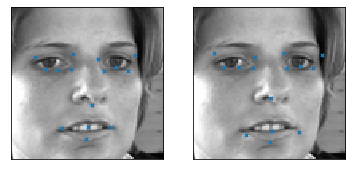

In [54]:
sample1 = load(test=True)[0][6:7]
sample2 = load2d(test=True)[0][6:7]
y_pred1 = model.predict(sample1)[0]
y_pred2 = model2.predict(sample2)[0]

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1, y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample2, y_pred2, ax)
plt.show()